# 2 Chip 2D Hadamard

In [85]:
TT.freeTimeTagger(tagger)

True

In [1]:
#run this cell if you want to be able to autoreload packages
#(meaning that you don't have to restart the kernal when you make changes to code)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%run -i "prerequisites.py"

In [3]:
from scipy import optimize
from IPython.display import clear_output, display

In [4]:
# powermeter1 = Powermeter('PM100USB', serial='P2003916', unit='dBm', wavelength=1550) 
unit='mW'
wavelength=1550
#Charlie (tele) powermeters 10/03/20:
PM_C1 = PM('PM100USB', serial='P2007347',unit=unit, wavelength = wavelength)
PM_C2 = PM('PM100USB', serial='P2010371',unit=unit, wavelength = wavelength) 
PM_C3 = PM('PM100USB', serial='P2003683',unit=unit, wavelength = wavelength) 
PM_C4 = PM('PM100USB', serial='P2008115',unit=unit, wavelength = wavelength)
#Bob powermeters 10/03/20:
PM_B1 = PM('PM100USB', serial='P2005653',unit=unit, wavelength = wavelength)
PM_B2 = PM('PM100USB', serial='P2010372',unit=unit, wavelength = wavelength) 
PM_B3 = PM('PM100USB', serial='P2008116',unit=unit, wavelength = wavelength) 
PM_B4 = PM('PM100USB', serial='P2007346',unit=unit, wavelength = wavelength)

PM_signal = {"PM_C1":PM_C1,"PM_C2":PM_C2, "PM_C3":PM_C3,"PM_C4":PM_C4}
PM_idler = {"PM_B1":PM_B1,"PM_B2":PM_B2, "PM_B3":PM_B3,"PM_B4":PM_B4}
PM_all = {"PM_C1":PM_C1,"PM_C2":PM_C2, "PM_C3":PM_C3,"PM_C4":PM_C4, "PM_B1":PM_B1,"PM_B2":PM_B2, "PM_B3":PM_B3,"PM_B4":PM_B4}

### Laser

In [5]:
# Wavelengths
p_wavelength = 1549.3
i_wavelength = 1558.98
s_wavelength = 1539.77

unit='dBm'
serial_port_name = 'COM13'
mytunics = tunics(serial_port_name = serial_port_name, unit=unit)


Connected to Tunics laser on serial port COM13



In [6]:
# Laser Settings
mytunics.laser_wavelength(p_wavelength)
mytunics.laser_switch('on') 
mytunics.laser_power(14) 

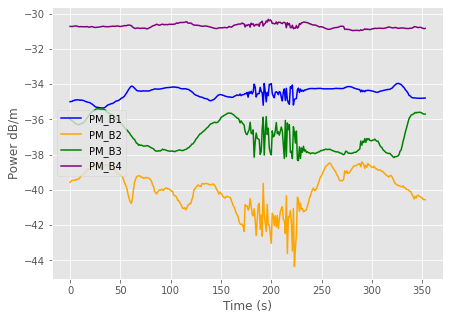

In [63]:
LP.live_opt_pow(heaters = PM_idler)

# Chip Config

In [7]:
#Alice
h.set_many_phases(CF.Alice_FP_23)
h.set_many_phases(CF.Bob_23_Comp)
h.set_many_phases(CF.Charlie_23_Comp)

In [7]:
Bob_phase_max_pow = {
    #Bob
    "Atta1":pi,
    "Atta2":pi,
    "Atta3":pi,
    "Atta4":0,
    "MZIa1":pi/2,
    "MZIa2":pi/2,
    "MZIa3":pi,
    "MZIa4":pi
    ,
    }
h.set_many_phases(Bob_phase_max_pow)

In [8]:
#Alice
h.set_many_phases({"BS1":pi/2,
    "BS2":pi/2-0.4,
    "BS3":pi/2-0.4,
    "WDM1":0,
    "WDM2":0,
    "WDM3":0,
    "WDM4":0,
    "Pre_RY1":pi,
    "Pre_RY2":pi,
    "Bell1":pi,
    "Bell2":pi,
    "Prj_RY1":pi,
    "Prj_RY2":pi,
    "Prj_RY3":pi,
    "Prj_RY4":pi,
    "Ctr_1":pi,
    "Ctr_2":pi,
    "Prj_RZ1":0,
    "Prj_RZ2":0,
    "Prj_RZ3":0,
    "Prj_RZ4":0,
    "Pre_RZ1":0,
    "Pre_RZ2":0,})

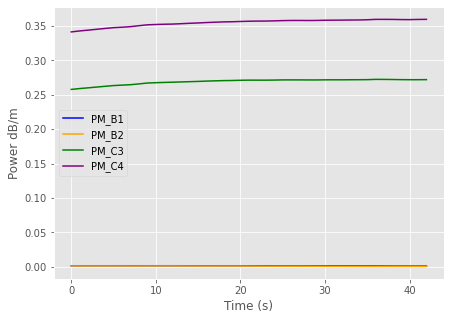

In [9]:
LP.live_opt_pow({"PM_B1":PM_B1,"PM_B2":PM_B2, "PM_C3":PM_C3,"PM_C4":PM_C4})

## Rings

In [10]:
# Read in Ring Volts
df = pd.read_csv("Ring_Coulping_Voltage.csv")
Ring_Volts = df.to_dict('r')[0]

In [11]:
# Setting the ring to have maximum number of entangled photons
for ring, volts in Ring_Volts.items():
    h.set_voltage(ring,volts)

In [12]:
ring = "MRR1"
h.set_voltage(ring,Ring_Volts[ring]-0.2)

In [16]:
ring = "MRR2"
h.set_voltage(ring,Ring_Volts[ring]-0.4)

In [18]:
ring = "MRR3"
h.set_voltage(ring,Ring_Volts[ring]-0.2)

In [20]:
ring = "MRR4"
h.set_voltage(ring,Ring_Volts[ring]-0.2)

# 2D Hadamard

In [66]:
class StabilisedMeasurements(MultiChipStabilisation):
    
    def measure(self, length, n_values, binwidth, *stab_channels):
        results = []
        Counter = TT.Counter(tagger, coinc_chans, binwidth = binwidth, n_values = n_values)
        Counter.clear()
        for i in range(0,length):
            self.stabilisation(self, *stab_channels)
            time.sleep(binwidth/(10**12)*n_values)
            results.append(Counter.getData())
            Counter.clear()
        
        return results
    

NameError: name 'MultiChipStabilisation' is not defined

In [21]:
class MultiChipStabilisation():
    
    def __init__(self):
        pass
        
    def multi_stabilise(self, *stab_channels):
        self.multi_sweep(self, *stab_channels)
        while True:
            for index, channel in enumerate(stab_channels):
                fringe_dict = channel.stabilise_sweep()
                params = channel.fit(fringe_dict)
                channel.stabilise(params)
                time.sleep(1/len(stab_channels))
                clear_output(wait=True)
                print("Stabilising", index)
                
    def stabilisation(self, *stab_channels):
        for index, channel in enumerate(stab_channels):
            fringe_dict = channel.stabilise_sweep()
            params = channel.fit(fringe_dict)
            channel.stabilise(params)
        return True
                
    def multi_sweep(self, *stab_channels):
        for channel in stab_channels:
            channel.stabilise_sweep(True)
        return True
    
    def length(self, length):
        self.length = length
        return self.length
    
    def n_values(self, n_values):
        self.n_values = n_values
        return self.n_values
    
    def binwidth(self, binwidth):
        self.binwidth = binwidth
        return self.binwidth
    
    def measure(self, *stab_channels):
        results = []
        Counter = TT.Counter(tagger, coinc_chans, binwidth = self.binwidth, n_values = self.n_values)
        Counter.clear()
        for i in range(0,self.length):
            self.stabilisation(*stab_channels)
            Counter.clear()
            time.sleep(self.binwidth/(10**12)*self.n_values)
            results.append(Counter.getData())
            clear_output(wait=True)
            print(i, "/", self.length)
        
        return results
    
    class PhaseStabilisation():

        def __init__(self, heater,
                    pow_met,
                    ):

            self.heater = heater
            self.pow_met = pow_met

        def stabilise_sweep(self, cal = False):
            self.fringe_dict = {}
            if cal:
                phase_range = self.phase_range(0, 2*pi, pi/10)
            else:
                phase_range = self.phase_range(0, 2*pi, pi/4)

            for phase in phase_range:
                h.set_phase(self.heater, phase)
                time.sleep(0.1)
                self.fringe_dict[phase] = self.pow_met.measure()

            return self.fringe_dict

        def fit(self, fringe_dict):
            phase_list = list(self.fringe_dict.keys())
            power_list = list(self.fringe_dict.values())
            initial_guess=[max(power_list), 0.5, 0, min(power_list)]
            param_bounds=([0, 0.3, -np.inf, 0], [2*max(power_list), 0.8, np.inf, max(power_list)]) # upper bound of amplitude could be given as related to the maximum power when not interfering?
            self.params, pcov = optimize.curve_fit(self.SineSq, phase_list, power_list, bounds = param_bounds, p0 = initial_guess)

    #         fit_phase_list = np.linespace(0, 2*pi, 30)
    #         sin_fit = SineSq(fit_phase_list, params[0], params[1], params[2], params[3])

            return self.params

        def stabilise(self, params):
            return h.set_phase(self.heater, -self.params[2]/self.params[1])

        def stabilisation(self):
            self.stabilise_sweep(True)
            while True:
                fringe_dict = self.stabilise_sweep()
                params = self.fit(fringe_dict)
                self.stabilise(params)
                time.sleep(1)
                print("Stabilised")


        def SineSq(self, x, amp, freq, phi_0, y_off):
            return amp*np.sin(freq*x+phi_0)**2+y_off

        def phase_range(self, start, stop, reso):
            return np.arange(start, stop, reso)

# Q. Measurements

In [25]:
%run -i "SC_Prerequisites.py"

In [31]:
## Configruation of the swabian setting the trigger levels for each channels and the input delays needed
channels = [1,2,3,4,5,6,7,8]
trigger_levels = {1:0.08, 2:0.08, 3:0.08, 4:0.08, 5:0.08, 6:0.08, 7:0.08, 8:0.08}
AB_input_delays = {1:0, 2:0, 3:0, 4:0, 5:60000, 6:27000, 7:42000, 8:42000}


SC.set_input_delays(AB_input_delays, tagger)
SC.set_trigger_levels(trigger_levels, tagger)

In [32]:
Coin_Combs = SC.Virutal_channel_creator() # Creates a list of list of the coindient channels, with the number enter being the number of channels used. 
coinc = TT.Coincidences(tagger, Coin_Combs, coincidenceWindow=1000) # Creates all of the coincdent channells of all the combinations from Coin_combs
coinc_chans = list(coinc.getChannels())  # Creates a list of the channel numbers


## Creates a Dict of the channels and the keys being the coincdent of the channels Example {"Ch[1,2]:19. Ch[1,3]:20...., Ch[7,8]:36"}
Coin_channel_dict = {}
i = 0
for channel in coinc_chans:
    Coin_channel_dict["Ch"+str(Coin_Combs[i])] = channel
    i += 1
    
## Creates a dictonry of the channels of the Coincdent channels are actually at, so each value is a class. 
Channels_Coinc = {}
for key, channel in Coin_channel_dict.items():
    Channels_Coinc[key] = TT.Countrate(tagger,[channel])

In [34]:
MCS = MultiChipStabilisation()

In [35]:
Bob_stab_1 = MCS.PhaseStabilisation("Pha1", PM_B1)
Bob_stab_2 = MCS.PhaseStabilisation("Pha3", PM_B3)

In [36]:
MCS.length = 300
MCS.binwidth = 10**10
MCS.n_values = 100

In [38]:
results =  MCS.measure(Bob_stab_1, Bob_stab_2)

299 / 300


In [40]:
summed_results = []
for sweep in results:
    buffer = []
    for channel in sweep:
        buffer.append(channel.sum())
    summed_results.append(buffer)

In [41]:
processed_results = []
np.array(summed_results)
for index in range(len(summed_results[0])):
    channel = []
    for row in summed_results:
        channel.append(row[index])
    processed_results.append(np.array(channel).sum())

In [42]:
processed_results

[15914,
 9767,
 3275,
 13838,
 1808,
 4383,
 3721,
 7871,
 10022,
 48026,
 4158,
 16579,
 1592,
 3908,
 1697,
 26085]

In [43]:
save_path = "results/Counts_results_2D_2Chip_Had_twice"
Save_Results(processed_results, save_path)

In [44]:
AB_input_delays = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
SC.set_input_delays(AB_input_delays, tagger)

In [45]:
coinc = TT.Coincidences(tagger, Coin_Combs, coincidenceWindow=10000) # Creates all of the coincdent channells of all the combinations from Coin_combs
coinc_chans = list(coinc.getChannels())  # Creates a list of the channel numbers

In [46]:
MCS = MultiChipStabilisation()

In [47]:
Bob_stab_1 = MCS.PhaseStabilisation("Pha1", PM_B1)
Bob_stab_2 = MCS.PhaseStabilisation("Pha3", PM_B3)

In [48]:
MCS.length = 300
MCS.binwidth = 10**10
MCS.n_values = 100

In [49]:
results =  MCS.measure(Bob_stab_1, Bob_stab_2)

299 / 300


In [51]:
summed_results = []
for sweep in results:
    buffer = []
    for channel in sweep:
        buffer.append(channel.sum())
    summed_results.append(buffer)

In [52]:
processed_results = []
np.array(summed_results)
for index in range(len(summed_results[0])):
    channel = []
    for row in summed_results:
        channel.append(row[index])
    processed_results.append(np.array(channel).sum())

In [53]:
processed_results

[11845,
 11407,
 14737,
 62962,
 12632,
 11490,
 15392,
 63382,
 12828,
 12087,
 16059,
 66425,
 12171,
 10561,
 14598,
 57609]

In [54]:
save_path = "results/Counts_results_2D_2Chip_Had_twice_background"
Save_Results(processed_results, save_path)

In [55]:
Bob_phase_max_pow = {
    #Bob
    "Atta1":pi,
    "Atta2":pi,
    "Atta3":pi,
    "Atta4":0,
    "MZIa1":pi,
    "MZIa2":pi,
    "MZIa3":pi,
    "MZIa4":pi
    ,
    }


h.set_many_phases(Bob_phase_max_pow)

In [58]:
Counter = TT.Counter(tagger, channels, binwidth = 10**12, n_values = 10)
Counter.clear()
time.sleep(10)
results = Counter.getData()

In [59]:
save_path = "results/Counts_results_2D_2Chip_Singles"
Save_Results(results, save_path)